# Time Series Forecasting Youtube Tutorial
## Using Machine Learning to Forecast Energy Consumption

This notebook is accompanied by a Youtube tutorial.

[WATCH THE VIDEO HERE](https://youtu.be/vV12dGe_Fho)

[You can find it on my channel here!](https://www.youtube.com/channel/UCxladMszXan-jfgzyeIMyvw)

![](https://res.cloudinary.com/monday-blogs/w_768,h_384,c_fit/fl_lossy,f_auto,q_auto/wp-blog/2021/05/sales-forecasting-software.jpg)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

## Types of Time Series Data

![](https://miro.medium.com/max/1400/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)

reference: https://engineering.99x.io/time-series-forecasting-in-machine-learning-3972f7a7a467

In [2]:
df = pd.read_csv('../input/hourly-energy-consumption/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

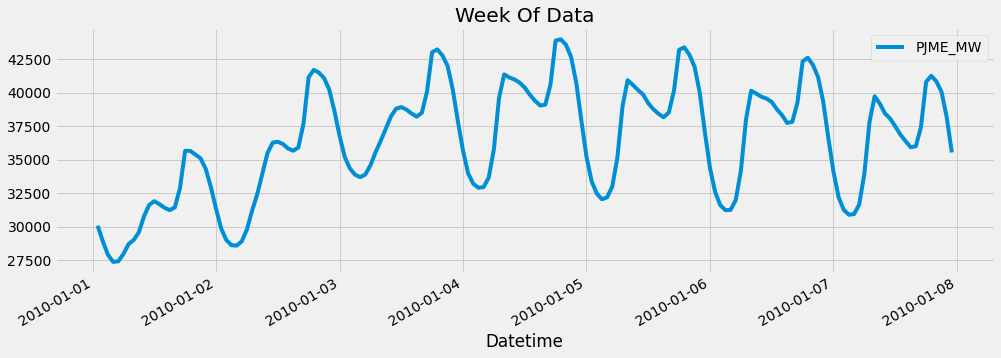

In [3]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

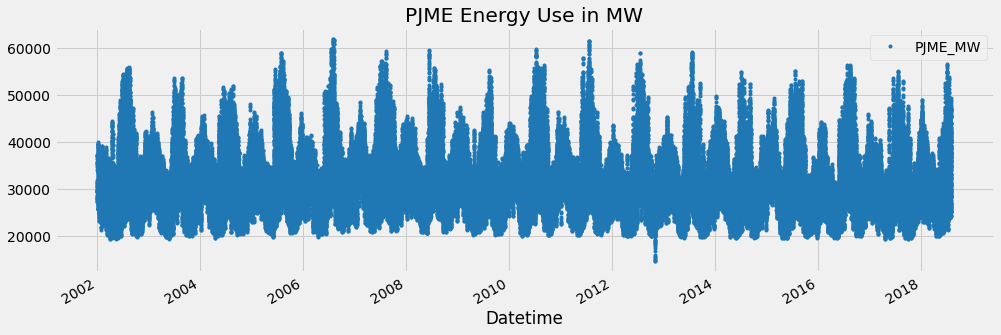

In [4]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

# Feature Creation

In [5]:
def create_features(df):
    df=df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month']= df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

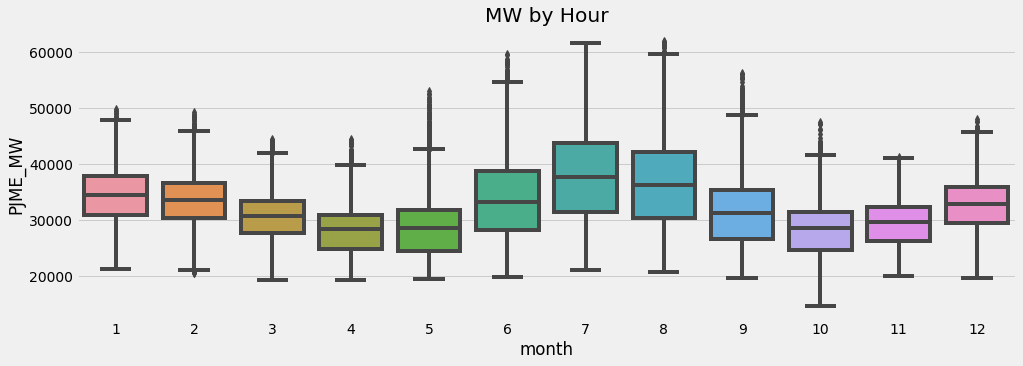

In [6]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x='month',y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

# Create Model

In [7]:
from sklearn.metrics import mean_squared_error

In [8]:
train = create_features(df)
test = create_features(df)
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'month', 'year', 'dayofyear'], dtype='object')

In [9]:
FEATURES = ['hour', 'dayofweek', 'month', 'year', 'dayofyear']
TARGET = "PJME_MW"

In [10]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [11]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,
                       learning_rate = 0.01)
reg.fit(X_train , y_train,
       eval_set=[(X_train,y_train), (X_test,y_test)],
       verbose=100)

[0]	validation_0-rmse:32401.44974	validation_1-rmse:32401.44974
[100]	validation_0-rmse:12296.83845	validation_1-rmse:12296.83845
[200]	validation_0-rmse:5412.14578	validation_1-rmse:5412.14578
[300]	validation_0-rmse:3481.60399	validation_1-rmse:3481.60399
[400]	validation_0-rmse:3022.09492	validation_1-rmse:3022.09492
[500]	validation_0-rmse:2850.72444	validation_1-rmse:2850.72444
[600]	validation_0-rmse:2774.97006	validation_1-rmse:2774.97006
[700]	validation_0-rmse:2699.51134	validation_1-rmse:2699.51134
[800]	validation_0-rmse:2630.66124	validation_1-rmse:2630.66124
[900]	validation_0-rmse:2577.29852	validation_1-rmse:2577.29852
[999]	validation_0-rmse:2542.66632	validation_1-rmse:2542.66632


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

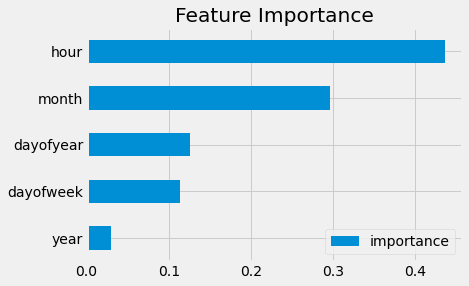

In [12]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
                 columns=['importance'])
fi.sort_values('importance').plot(kind="barh", title="Feature Importance")
plt.show()

# Forecast

In [13]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test['prediction'], how="left", left_index=True, right_index=True)

In [14]:
df.head(5)

,PJME_MW,hour,dayofweek,month,year,dayofyear,prediction
Datetime,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,2002,1,28349.433594
2002-01-01 02:00:00,29265.0,2,1,1,2002,1,27405.300781
2002-01-01 03:00:00,28357.0,3,1,1,2002,1,26998.941406
2002-01-01 04:00:00,27899.0,4,1,1,2002,1,26993.296875
2002-01-01 05:00:00,28057.0,5,1,1,2002,1,27524.478516


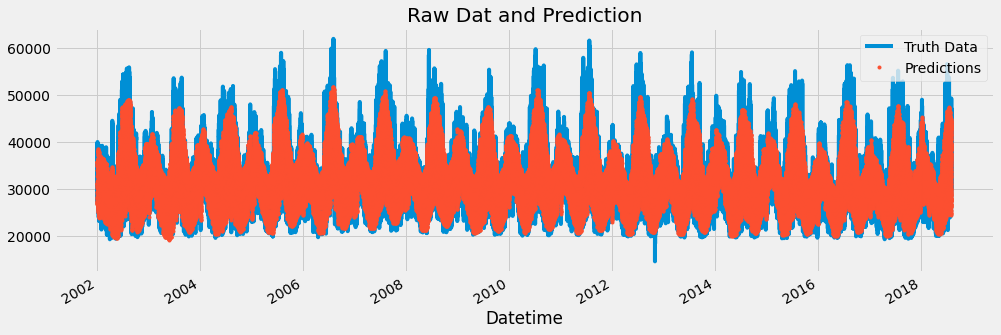

In [17]:
ax = df[['PJME_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [21]:
score = np.sqrt(mean_squared_error(test["PJME_MW"], test['prediction']))
score

2542.6663151693965